In [1]:
import sys

sys.path.insert(1, '..')
from functions.other_functions import process_date, process_exposure, chi2, linear
import ROOT
import numpy as np
import random
import time as tm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import xml.dom.minidom as minidom

Welcome to JupyROOT 6.24/02


In [2]:
import matplotlib.pyplot as plt
from matplotlib import cycler, patches

IPython_default = plt.rcParams.copy()
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

figsize = (4.5, 3)

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.family"] = "serif"

marker_size = 3
line_width = 0.5

colors = cycler('color', ['#EE6666', '#3388BB', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB', '#653700', '#F97306'])
plt.rc('axes', facecolor='white', edgecolor='black',
       axisbelow=True, grid=True, prop_cycle=colors)



Store the information from the root file output from the xml_reader.cpp

In [3]:
root_file = ROOT.TFile("/Users/williamquinn/Desktop/PMT_Project/200117_A1400_B1400_t1003.root", "READ")
tree = root_file.T

In [4]:
n_charges = [[], []]
n_amplitudes = [[], []]
n_baselines = [[], []]
n_pars = [[], []]
n_trigger_nums = [[], []]
n_pulse_times = [[], []]
for event in tree:
    OM_ID = int(event.OM_ID)
    pars = list(event.pulse_charge_parameters)
    
    trigger_num = int(event.trigger_num)
    n_trigger_nums[OM_ID].append(trigger_num)
    
    charge = float(event.pulse_charge)
    n_charges[OM_ID].append(charge)
    
    baseline = float(event.pulse_baseline)
    n_baselines[OM_ID].append(baseline)
    
    amplitude = float(event.pulse_amplitude)
    n_amplitudes[OM_ID].append(amplitude)
    
    time = event.pulse_time
    n_pulse_times[OM_ID].append(time)

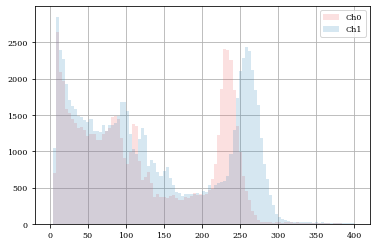

In [5]:
freq_0, bin_edges = np.histogram(np.array(n_charges[0]), 100, range=(0, 400))
width = bin_edges[-1] - bin_edges[-2]
bin_centres = bin_edges[:-1] + width / 2
freq_1, bin_edges = np.histogram(np.array(n_charges[1]), 100, range=(0, 400))
width = bin_edges[-1] - bin_edges[-2]
bin_centres = bin_edges[:-1] + width / 2

plt.bar(bin_centres, freq_0, width=width, alpha=0.2, label='Ch0')
plt.bar(bin_centres, freq_1, width=width, alpha=0.2, label='Ch1')
plt.legend(loc='best')
# plt.ylim(0,4000)

Create python version fo the functions used in the C++ file

In [18]:
def get_pulse_from_root_file( filename ):
    pulses = [[], []]
    pulse_root_file = ROOT.TFile(filename, "READ")
    for itemp in range(2):
        temp_vector = []
        hist_name = "1400V_pulse_30ns_Ch{}".format(itemp)

        template_hist = pulse_root_file.Get(hist_name)

        for ihist in range(1, int(template_hist.GetEntries()) + 1):
            temp_vector.append(template_hist.GetBinContent(ihist));
        del template_hist

        pulses[itemp] = (temp_vector)
            
    pulse_root_file.Close()
    
    pulses = [-1*np.array(pulses[0])/np.amin(pulses[0]), -1*np.array(pulses[1])/np.amin(pulses[1])]

    return pulses

def get_baseline( vec ):
    pre_trigger = 500
    baseline = 0
    for i_vec in range(pre_trigger):
        baseline += vec[i_vec]
    return baseline/pre_trigger

def get_amplitude( vec, baseline ):
    amplitude = vec[0]
    for i_vec in range(len(vec)):
        if vec[i_vec] < amplitude:
            amplitude = vec[i_vec]
    return (-1)*(amplitude - baseline)

def get_charge( vec, baseline, peak_cell ):
    charge = 0.0
    for i_ch in range(peak_cell - 10, peak_cell + 20):
        charge += vec[i_ch] - baseline
    return (-1.0)*charge/50

def get_peak_cell( vec ):
    peak_cell = 0
    temp = vec[0]
    for i_vec in range(len(vec)):
        if vec[i_vec] < temp:
            temp = vec[i_vec]
            peak_cell = i_vec
    
    return peak_cell

def check_saturation(waveform, peak_cell):

    for i in range(550, 750):
        if waveform[i] == 0.0:
            return True
    return False


In [19]:
def get_sat_charge(vec, baseline, av_pulse, channel, peak_cell ):
    pos = []
    done_pos = False
    for i_vec in range(550, 750):
        if vec[i_vec] == 0.0:
            done_pos = True
            pos.append(i_vec)
        else:
            if (done_pos):
                break

    middle = int(len(pos) / 2)
    the_pos = pos[middle]

    pulse_r = []
    pulse = []
    new_pulse = []
    xi = []
    for i_pos in range(the_pos - 10, the_pos + 20):
        pulse_r.append(vec[i_pos] - baseline)
        pulse.append(vec[i_pos])

    graph = ROOT.TGraphErrors()
    n_point = 0
    for j in range(len(pulse)):
        if j > 14:
            break
        
        if pulse[j] == 0:
            continue
        else:
            new_pulse.append(pulse_r[j])
            xi.append(j)
            graph.SetPoint(n_point, j, pulse_r[j])
            graph.SetPointError(n_point, 0, np.sqrt(abs(pulse_r[j])))
            n_point+=1

    temp_std = 0
    if channel == 0:
        temp_std = 2.22
    else:
        temp_std = 2.14
    

    fit = ROOT.TF1("fit", "[0]*TMath::Gaus(x, [1],{})".format(temp_std), 0, 14)
    fit.SetParLimits(0, -3500, -900)
    fit.SetParLimits(1, 5, 15)
    fit.SetParameters(-1001, 10)

    graph.Fit("fit", "0Q", "", 0, 14)
    A = fit.GetParameter(0)
    mu = fit.GetParameter(1)

    if A < -3500 or A > -900:
        print("The code is breaking the laws of physics")

    charge = 0.0
    for k in range(len(av_pulse)):
        charge += av_pulse[k]
    charge = charge * A / 50

    pulse_pars = []
    pulse_pars.append(charge);
    pulse_pars.append(fit.GetParameter(0))
    pulse_pars.append(fit.GetParError(0))
    pulse_pars.append(fit.GetParameter(1))
    pulse_pars.append(fit.GetParError(1))

    del graph
    del fit

    return pulse_pars

Parse the xml file to be read in for python prossessing

In [8]:
filename = "/Users/williamquinn/Desktop/PMT_Project/200117_A1400_B1400_t1003.xml"
file = minidom.parse(filename)
traces = file.getElementsByTagName('trace')

Read in the PMT template pulses

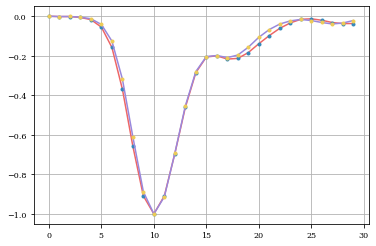

In [9]:
temp_pulse = get_pulse_from_root_file("/Users/williamquinn/Desktop/PMT_Project/1400V_pulse_30ns.root")
plt.plot(-1*temp_pulse[0]/np.amin(temp_pulse[0]))
plt.plot(-1*temp_pulse[0]/np.amin(temp_pulse[0]), ".")
plt.plot(-1*temp_pulse[1]/np.amin(temp_pulse[1]))
plt.plot(-1*temp_pulse[1]/np.amin(temp_pulse[1]), ".")

In [20]:
counter = 0
fit_counter = 0
charges = [[], []]
amplitudes = [[], []]
baselines = [[], []]
ap_charges = [[], []]
trigger_nums = [[], []]
pars = [[], []]
for i in range(int(traces.length)):
    trace = traces[i].firstChild.data.split(" ")[1:-1]
    channel = int(traces[i].attributes['channel'].value)
    
    if i % 10000 == 0:
        print(i)
    
    waveform = np.array(trace, dtype='float')

    baseline = get_baseline(waveform)
    peak = get_peak_cell(waveform)
    #print("peak: ",peak)
        
    if peak < 550:
        continue
    elif peak > 750:
        continue
        
    amplitude = get_amplitude(waveform, baseline)
    #print("amplitude: ",amplitude)
        
    if amplitude < 50:
        continue
            
    is_sat = check_saturation(waveform, peak)
        
    if is_sat:
        temp_pars = get_sat_charge(waveform, baseline, temp_pulse[channel], channel, peak)
        if len(temp_pars) == 0: 
            charge = 0
        else:
            charge = temp_pars[0]
    else:
        charge = get_charge(waveform, baseline, peak)
        
    #print("charge: ", charge)

    if charge < 6:
        continue
            
    amplitudes[channel].append(amplitude)
    baselines[channel].append(baseline)
    charges[channel].append(charge)
    pars[channel].append(temp_pars)
    trigger_nums[channel].append(i)
    

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000


In [21]:
print(len(charges[0]), len(n_charges[0]), len(charges[0])-len(n_charges[0]))
print(len(charges[1]), len(n_charges[1]), len(charges[1])-len(n_charges[1]))
print(len(amplitudes[0]), len(n_amplitudes[0]))
print(len(amplitudes[1]), len(n_amplitudes[1]))
print(len(baselines[0]), len(n_baselines[0]))
print(len(baselines[1]), len(n_baselines[1]))
print(len(trigger_nums[0]), len(n_trigger_nums[0]))
print(len(trigger_nums[1]), len(n_trigger_nums[1]))

66803 66803 0
84631 84631 0
66803 66803
84631 84631
66803 66803
84631 84631
66803 66803
84631 84631


In [23]:
print(False in (np.array(charges[0]) == np.array(n_charges[0])))
print(False in (np.array(charges[1]) == np.array(n_charges[1])))
print(False in (np.array(amplitudes[0]) == np.array(n_amplitudes[0])))
print(False in (np.array(amplitudes[1]) == np.array(n_amplitudes[1])))
print(False in (np.array(baselines[0]) == np.array(n_baselines[0])))
print(False in (np.array(baselines[1]) == np.array(n_baselines[1])))

True
True
False
False
False
False
